# The Whole Shebang

Due to bugs in previous notebooks, it behooves me to rewrite Wang's model following the code he provided me. Things to keep in mind are:
* modularisation for interpretability
* parallelisability with Dask
* phenotype-input interpretation for the evolutionary algorithm

## Section: Initialise

First we initialise the project, set seeds, and set parameters. This will be the go-to place for changing parameters for simulations. Hence parameters that may not always be used are included here.

These parameters (network, neuron, noise and learning) are the features which will be adapted via the evolutionary algorithm. There may be more adapting parameters, such as topological ones for connectivity or coefficients for the eligibility-trace learning rule Taylor expansion, and non-adapting parameters, such as a bias for selecting the next stimulus.

### Synapses

Wang's model critically uses conductance-based synapses, with differing dynamics for AMPA and NMDA receptors, as well as for GABA receptors. Hence we need to specify reversal potentials $V_E$ for the AMPA and NMDA receptors and $V_I$ for GABA receptors. The conductance for synapses will be of the form $g_{type} \times s_{type}(t)$ where $s_{type}(t)$ will have dynamics depending on presynaptic spiking behaviour.

### Noise

Two types of noise are considered:  
* **Poisson noise** from external firing (as in Wang 2002)  
* **White noise** on the membrane potential  

We could also add noise to the conductances. I haven't included that here. The role of the white noise would be to ensure activity in an otherwise quiescent network. Initially it is zero anyway.  
Another type of noise would be escape noise. This is important for derivations of learning rules, but is more difficult to simulate in the current environment.

### Learning

The learning parameters for weight-dependent STDP and Vogels et al. iSTDP are from two distinct sources, and likely need scaling to function on similar time scales and network sizes. How to scale these is not obvious, nor is it clear that having one target rate (for iSTDP) will work with Wang's model, which has bistable states with two distinct rates. Learning in this manner may need to be turned off.

In [1]:
import brian2 as b2
from brian2 import numpy as np

b2.seed(3)
np.random.seed(3)

b2.start_scope()
b2.defaultclock.dt = 0.2 * b2.ms

defaultmethod = 'euler'

## Running times
T_run = 4000 * b2.ms  # full running time of experiment
stim_runtime = 2000 * b2.ms  # exposure time of stimulation
interstim_delay = 600 * b2.ms  # delay after assessing choice
# next two variables may be modified in response to action choices:
T_stim_start_initial = 300 * b2.ms  # starting time of first stimulation
T_stim_start = T_stim_start_initial  # updated in code
# stimulation ending time of first simulation:
T_stim_end_initial = T_stim_start_initial + stim_runtime
T_stim_end = T_stim_end_initial  # updated in code
# time after action choice ending to deliver reward:
reward_delay = 200 * b2.ms  # not currently used
# time after stimulus onset to begin sampling for action choice:
actionsel_delay = stim_runtime
T_actionsel_start = T_stim_end + actionsel_delay

## Network parameters
N_E = 1600  # number of excitatory neurons
N_I = 400  # number of inhibitory neurons
f_sel = 0.15  # selective fraction of excitatory neurons
N_1 = int(f_sel * N_E)  # selective group size
N_2 = N_1
w_plus = 1.7

#############################################
##########    CHANGE MADE    ################
#############################################
w_plus = 2.0  # to compensate for lack of NMDA
#############################################

w_minus = 0.0 #(1 - w_plus * f_sel)/(1 - f_sel)  # from Wang code
w_else = 1.0
w_min = 0.0  # minimum weight
w_max = 10.0  # maximum weight
w_std = 0.0  # standard deviation for sampling weights
# selection threshold for action choice
# sampled at update_dt intervals:
choice_thresh = 15.0 * b2.Hz

## Input parameters
# timestep to update input rates and check for action selection:
update_dt = 50.0 * b2.ms
# number of timesteps to look back to check for action choice
lookback = int(update_dt / b2.defaultclock.dt)
coherence_level = -0.9
coherence_level_options = np.array([1, -1]) * coherence_level
coherence_option_probabilities = [0.5, 0.5]
stimulus_mean = 40.0 * b2.Hz  # baseline rate at zero coherence

#############################################
##########    CHANGE MADE    ################
#############################################
stimulus_mean = 60.0 * b2.Hz  # baseline rate at zero coherence
#############################################

stimulus_std = 10.0 * b2.Hz  # standard deviation for sampling rate
# connection prob. for many-to-many input layout
# if use_connection_probabilities:
input_connection_probability = 1.0
N_input_1 = N_1
N_input_2 = N_2
use_connection_probabilities = False

## Neuron and synapse parameters
V_leak = -70 * b2.mV
V_thresh = -50 * b2.mV
V_reset = -55 * b2.mV
# reversal potentials:
V_E = 0 * b2.mV
V_I = -70 * b2.mV
# time constants:
tau_mem_E = 20 * b2.ms
tau_mem_I = 10 * b2.ms
tau_refrac_E = 2 * b2.ms
tau_refrac_I = 1 * b2.ms
tau_AMPA = 2 * b2.ms
tau_GABA = 5 * b2.ms
tau_NMDA = 100 * b2.ms
tau_x = 2 * b2.ms  # tau_rise in Wang 2002
synapse_delay = 10 * b2.ms
# NMDA dynamics constants
alpha_NMDA = 0.5 * b2.kHz  # (ms)^-1
a_NMDA = 0.062 * b2.mV ** -1
b_NMDA = 3.57
Mg_conc = 1  # no units, this is dropped in Wang code
# leak conductances:
g_E = 25 * b2.nS
g_I = 20 * b2.nS
# synapse conductances (scaling from Wang code)...
# ... onto excitatory:
g_AMPA_external_E = 2.1 * b2.nS
g_AMPA_E = 80 * b2.nS / N_E
g_NMDA_E = 264 * b2.nS / N_E 
g_GABA_E = 520 * b2.nS / N_I
# ... onto inhibitory:
g_AMPA_external_I = 1.62 * b2.nS
g_AMPA_I = 64 * b2.nS / N_E
g_NMDA_I = 208 * b2.nS / N_E
g_GABA_I = 400 * b2.nS / N_I

## Noise parameters
# background_noise_rate = 2.4 * b2.kHz
# background_noise_rate / stimulus_mean:
background_noise_stimulus_ratio = 45.0 # 52 # default 60 (48, 80 = -,+ 1 std)
# The mean driving force of background noise can be calculated from this...
background_noise_rate = background_noise_stimulus_ratio * stimulus_mean

# white noise can be turned off so that Runga-Kutta methods can
# be used (as opposed to Euler-Maruyama):
use_membrane_noise = False
# white noise (divided by square root of membrane time constant):
noise_membrane_std = 0.0 * b2.mV
# whether to use PoissonInput or PoissonGroup with 1-1 connectivity:
use_Poisson_input = False
# number of PoissonInput sources:
# (background_noise_rate is divided by this number)
N_background_traces = 1000

## Learning parameters
learning_rate = 1e-2  # as in Zenke code
# STDP params from the Brian2 tutorial
tau_pre = 20 * b2.ms
tau_post = 20 * b2.ms
A_pre_STDP = 0.01
A_post_STDP = -A_pre_STDP * 1.05
# weight dependence
mu_weight = 0.023  # 0.023=mu_crit from STDP, 0 for W-STDP
# iSTDP params from Vogels et al. 2011 (and Zenke code)
tau_iSTDP = 20 * b2.ms  # this may suffice to match tau_pre/post
# target rate parameter:
alpha_iSTDP = 3 * b2.Hz * tau_iSTDP * 2  # sic? from Zenke code...
A_pre_iSTDP = 1.0
A_post_iSTDP = 1.0
use_STDP = False  # whether to update synaptic weights with STDP
use_iSTDP = True  # whether to update synaptic weights with iSTDP

## Monitor parameters
# These parameters aren't used in the evolutionary algorithm,
# so they can probably be moved to their cells without confusion
statemonitor_dt = 1*b2.ms
max_neurons_per_population = 100
neurons_to_record_E = np.concatenate([
    np.arange(0, min(max_neurons_per_population, N_1)),
    np.arange(N_1, N_1+min(max_neurons_per_population, N_2)),
    np.arange(N_1+N_2, min(N_1+N_2+max_neurons_per_population, N_E))
])
neurons_to_record_I = np.arange(0, min(max_neurons_per_population, N_I))

## Section: Equations

Here are the update equations for the models. Subsections will include the neuron dynamics, the synapse dynamics, and the plasticity rules. Different types of neurons will have different rules guiding them.  
Interchanging between different implementations can follow an if-else structure, dependent on parameters in the **Initialise** section.

Since the equations for excitatory neurons and inhibitory neurons differ only in their constants, we can use `str.replace()` to insert the constants into the equations.

The appropriate spike-timing-dependent plasticity rules can be added to the appropriate `b2.Synapse`s upon their creation.

In [2]:
# # %%writefile sim_equations.py
# # from sim_initialise import *

# ## Neuron Equations
# # du/dt follows the layout from Wang's code, with noise added
# # 'ext' for external, or input
# # s_AMPA_ext describes external noise AND input stimulation.
# # It is not a summed variable, but incremented whenever background
# # noise or input stimulates the neurons.
# neuron_eqns = '''
#     I_syn = I_AMPA_ext + I_AMPA + I_NMDA + I_GABA : amp
#     I_AMPA_ext = AMPA_CONDUCTANCE_EXT * s_AMPA_ext * (u-V_E) : amp
#     ds_AMPA_ext/dt = -s_AMPA_ext / tau_AMPA : 1
#     I_AMPA = AMPA_CONDUCTANCE_REC * s_AMPA_total * (u-V_E) : amp
#     s_AMPA_total = s_1_AMPA_total + s_2_AMPA_total + s_other_AMPA_total : 1
#     s_1_AMPA_total : 1
#     s_2_AMPA_total : 1
#     s_other_AMPA_total : 1
#     I_NMDA = NMDA_CONDUCTANCE * s_NMDA_total * (u-V_E) / (1+Mg_conc*exp(-a_NMDA*u)/b_NMDA) : amp
#     s_NMDA_total = s_1_NMDA_total + s_2_NMDA_total + s_other_NMDA_total : 1
#     s_1_NMDA_total : 1
#     s_2_NMDA_total : 1
#     s_other_NMDA_total : 1
#     I_GABA = GABA_CONDUCTANCE * s_GABA_total * (u-V_I) : amp
#     s_GABA_total : 1
#     '''
# # add membrane equation with potential noise
# if use_membrane_noise:
#     neuron_eqns = '''
#         du/dt = (-(u-V_leak) - I_syn / LEAK_CONDUCTANCE) / TIMECONST + noise_membrane_std * xi / sqrt(TIMECONST) : volt (unless refractory)
#         ''' + neuron_eqns
# else:
#     neuron_eqns = '''
#         du/dt = (-(u-V_leak) - I_syn / LEAK_CONDUCTANCE) / TIMECONST : volt (unless refractory)
#         ''' + neuron_eqns
# excitatory_synapse_variables = '''
#     ds_AMPA/dt = -s_AMPA / tau_AMPA : 1
#     dx_NMDA/dt = -x_NMDA / tau_x : 1
#     ds_NMDA/dt = -s_NMDA / tau_NMDA + alpha_NMDA * x_NMDA * (1 - s_NMDA) : 1
#     '''
# inhibitory_synapse_variables = '''
#     ds_GABA/dt = -s_GABA / tau_AMPA : 1
#     '''
# neuron_eqns_excitatory = neuron_eqns.replace(
#     'LEAK_CONDUCTANCE', 'g_E').replace(
#     'TIMECONST', 'tau_mem_E').replace(
#     'AMPA_CONDUCTANCE_EXT','g_AMPA_external_E').replace(
#     'AMPA_CONDUCTANCE_REC', 'g_AMPA_E').replace(
#     'NMDA_CONDUCTANCE', 'g_NMDA_E').replace(
#     'GABA_CONDUCTANCE', 'g_GABA_E') + excitatory_synapse_variables
# neuron_eqns_inhibitory = neuron_eqns.replace(
#     'LEAK_CONDUCTANCE', 'g_I').replace(
#     'TIMECONST', 'tau_mem_I').replace(
#     'AMPA_CONDUCTANCE_EXT','g_AMPA_external_I').replace(
#     'AMPA_CONDUCTANCE_REC', 'g_AMPA_I').replace(
#     'NMDA_CONDUCTANCE', 'g_NMDA_I').replace(
#     'GABA_CONDUCTANCE', 'g_GABA_I') + inhibitory_synapse_variables

# threshold_eqn = 'u > V_thresh'
# reset_eqn = 'u = V_reset'

# ## Synapse Equations
# # SOURCE can be '1', '2' or 'other'
# synapse_eqns_excitatory = '''
#     w : 1
#     s_SOURCE_AMPA_total_post = w * s_AMPA_pre : 1 (summed)
#     s_SOURCE_NMDA_total_post = w * s_NMDA_pre : 1 (summed)
#     '''
# synapse_eqns_excitatory_1 = synapse_eqns_excitatory.replace(
#     'SOURCE', '1')
# synapse_eqns_excitatory_2 = synapse_eqns_excitatory.replace(
#     'SOURCE', '2')
# synapse_eqns_excitatory_other = synapse_eqns_excitatory.replace(
#     'SOURCE', 'other')
# # incrementing presynaptic conductance variable because that's 
# # where we store the value for all synapses sharing the same 
# # presynaptic neuron
# # x_NMDA_pre += 1
# # s_AMPA_pre += 1
# excitatory_on_pre = '''
#     x_NMDA_pre = clip(x_NMDA_pre + 1, 0, 1)
#     s_AMPA_pre = clip(s_AMPA_pre + 1, 0, 1)
#     '''
# synapse_eqns_inhibitory = '''
#     w : 1
#     s_GABA_total_post = w * s_GABA_pre : 1 (summed)
#     '''
#     # s_GABA_pre += 1
# inhibitory_on_pre = '''
#     s_GABA_pre = clip(s_GABA_pre + 1, 0, 1)
#     '''
# # input synapses directly increment s_AMPA_ext
# # and only have weights for plasticity
# synapse_eqns_input = '''
#     w : 1
#     '''
# input_on_pre = '''
#     s_AMPA_ext_post += w
#     '''
# # s_AMPA_ext_post += s_AMPA

# ## Learning Equations
# if use_STDP:  # uses weight-dependent STDP
#     STDP_trace_eqns = '''
#         dapre/dt = -apre/tau_pre : 1 (event-driven)
#         dapost/dt = -apost/tau_post : 1 (event-driven)
#         '''
#     STDP_on_pre = '''
#         apre += A_pre_STDP
#         w = clip(w+learning_rate*apost*(w**mu_weight), 0, w_max)
#         '''
#     STDP_on_post = '''
#         apost += A_post_STDP
#         w = clip(w+learning_rate*apre*w, 0, w_max)
#         '''
# else:
#     STDP_trace_eqns = ''
#     STDP_on_pre = ''
#     STDP_on_post = ''

# if use_iSTDP:  # uses Vogel's et al. iSTDP from Zenke code
#     iSTDP_trace_eqns = '''
#         dapre/dt = -apre/tau_iSTDP : 1 (event-driven)
#         dapost/dt = -apost/tau_iSTDP : 1 (event-driven)
#         '''
#     iSTDP_on_pre = '''
#         apre += A_pre_iSTDP
#         w = clip(w+learning_rate*(apost-alpha_iSTDP), 0, w_max)
#         '''
#     iSTDP_on_post = '''
#         apost += A_post_iSTDP
#         w = clip(w+learning_rate*apre, 0, w_max)
#         '''
# else:
#     iSTDP_trace_eqns = ''
#     iSTDP_on_pre = ''
#     iSTDP_on_post = ''

Question: do we want to use the synaptic strength at the time of firing (increment $s$ by $w$) or do we want to use it at the current time (set $s_{total}(t)$ to $s(t)$ * $w(t)$)? I'm going with the latter below.

**TODO:** The AMPA synapses (which decay all at the same rate, and rise all at the same rate) could be on the postsynaptic neurons to reduce decay decrement computations, which by linearity should be the same.

In [3]:
## Neuron Equations
# du/dt follows the layout from Wang's code, with noise added
# 'ext' for external, or input
# s_AMPA_ext describes external noise AND input stimulation.
# It is not a summed variable, but incremented whenever background
# noise or input stimulates the neurons.

# In the original model, external inputs had no weights (so 
# s_AMPA_w_sum_ext would be incremented by w=1) because no
# learning was used.
# By linearity, decaying s_AMPA_w_sum_ext should be the same
# as decaying s_AMPA_ext and then multiplying by w
neuron_eqns = '''
    I_syn = I_AMPA_ext + I_AMPA + I_NMDA + I_GABA : amp
    I_AMPA_ext = AMPA_CONDUCTANCE_EXT * s_AMPA_w_sum_ext * (u-V_E) : amp
    ds_AMPA_w_sum_ext/dt = -s_AMPA_w_sum_ext / tau_AMPA : 1
    
    I_AMPA = AMPA_CONDUCTANCE_REC * s_AMPA_w_sum_total * (u-V_E) : amp
    s_AMPA_w_sum_1 : 1
    s_AMPA_w_sum_2 : 1
    s_AMPA_w_sum_other : 1
    s_AMPA_w_sum_total = s_AMPA_w_sum_1 + s_AMPA_w_sum_2 + s_AMPA_w_sum_other : 1
    
    I_NMDA = NMDA_CONDUCTANCE * s_NMDA_w_sum_total * (u-V_E) / (1+Mg_conc*exp(-a_NMDA*u)/b_NMDA) : amp
    s_NMDA_w_sum_1 : 1
    s_NMDA_w_sum_2 : 1
    s_NMDA_w_sum_other : 1
    s_NMDA_w_sum_total = s_NMDA_w_sum_1 + s_NMDA_w_sum_2 + s_NMDA_w_sum_other : 1
    
    I_GABA = GABA_CONDUCTANCE * s_GABA_w_sum * (u-V_I) : amp
    s_GABA_w_sum : 1
    '''
# add membrane equation with potential noise
if use_membrane_noise:
    neuron_eqns = '''
        du/dt = (-(u-V_leak) - I_syn / LEAK_CONDUCTANCE) / TIMECONST + noise_membrane_std * xi / sqrt(TIMECONST) : volt (unless refractory)
        ''' + neuron_eqns
else:
    neuron_eqns = '''
        du/dt = (-(u-V_leak) - I_syn / LEAK_CONDUCTANCE) / TIMECONST : volt (unless refractory)
        ''' + neuron_eqns

neuron_eqns_excitatory = neuron_eqns.replace(
    'LEAK_CONDUCTANCE', 'g_E').replace(
    'TIMECONST', 'tau_mem_E').replace(
    'AMPA_CONDUCTANCE_EXT','g_AMPA_external_E').replace(
    'AMPA_CONDUCTANCE_REC', 'g_AMPA_E').replace(
    'NMDA_CONDUCTANCE', 'g_NMDA_E').replace(
    'GABA_CONDUCTANCE', 'g_GABA_E')
neuron_eqns_inhibitory = neuron_eqns.replace(
    'LEAK_CONDUCTANCE', 'g_I').replace(
    'TIMECONST', 'tau_mem_I').replace(
    'AMPA_CONDUCTANCE_EXT','g_AMPA_external_I').replace(
    'AMPA_CONDUCTANCE_REC', 'g_AMPA_I').replace(
    'NMDA_CONDUCTANCE', 'g_NMDA_I').replace(
    'GABA_CONDUCTANCE', 'g_GABA_I')

threshold_eqn = 'u > V_thresh'
reset_eqn = 'u = V_reset'

## Synapse Equations
excitatory_synapse_variables = '''
    ds_AMPA/dt = -s_AMPA / tau_AMPA : 1 (clock-driven)
    dx_NMDA/dt = -x_NMDA / tau_x : 1 (clock-driven)
    ds_NMDA/dt = -s_NMDA / tau_NMDA + alpha_NMDA * x_NMDA * (1 - s_NMDA) : 1 (clock-driven)
    '''
inhibitory_synapse_variables = '''
    ds_GABA/dt = -s_GABA / tau_AMPA : 1 (clock-driven)
    '''

synapse_eqns_excitatory = '''
    w : 1
    s_NMDA_w_sum_SOURCE_post = w * s_NMDA : 1 (summed)
    s_AMPA_w_sum_SOURCE_post = w * s_AMPA : 1 (summed)
    ''' + excitatory_synapse_variables
synapse_eqns_excitatory_1 = synapse_eqns_excitatory.replace(
    'SOURCE', '1')
synapse_eqns_excitatory_2 = synapse_eqns_excitatory.replace(
    'SOURCE', '2')
synapse_eqns_excitatory_other = synapse_eqns_excitatory.replace(
    'SOURCE', 'other')

excitatory_on_pre = '''
    x_NMDA += 1
    s_AMPA += 1
    '''

#############################################
##########    CHANGE MADE    ################
#############################################
# turning of x should turn of NMDA activity
excitatory_on_pre = '''
    s_AMPA += 1
    '''
#############################################

# moving this line to being an event driven effect
# s_GABA_total_post = w * s_GABA : 1 (summed)
synapse_eqns_inhibitory = '''
    w : 1
    s_GABA_w_sum_post = w * s_GABA : 1 (summed)
    ''' + inhibitory_synapse_variables
inhibitory_on_pre = '''
    s_GABA += 1
    '''
# input synapses directly increment s_AMPA_ext
# and only have weights for plasticity
synapse_eqns_input = '''
    w : 1
    '''
input_on_pre = '''
    s_AMPA_w_sum_ext_post += w
    '''

## Learning Equations
if use_STDP:  # uses weight-dependent STDP
    STDP_trace_eqns = '''
        dapre/dt = -apre/tau_pre : 1 (event-driven)
        dapost/dt = -apost/tau_post : 1 (event-driven)
        '''
    STDP_on_pre = '''
        apre += A_pre_STDP
        w = clip(w+learning_rate*apost*(w**mu_weight), 0, w_max)
        '''
    STDP_on_post = '''
        apost += A_post_STDP
        w = clip(w+learning_rate*apre*w, 0, w_max)
        '''
else:
    STDP_trace_eqns = ''
    STDP_on_pre = ''
    STDP_on_post = ''

if use_iSTDP:  # uses Vogel's et al. iSTDP from Zenke code
    iSTDP_trace_eqns = '''
        dapre/dt = -apre/tau_iSTDP : 1 (event-driven)
        dapost/dt = -apost/tau_iSTDP : 1 (event-driven)
        '''
    iSTDP_on_pre = '''
        apre += A_pre_iSTDP
        w = clip(w+learning_rate*(apost-alpha_iSTDP), 0, w_max)
        '''
    iSTDP_on_post = '''
        apost += A_post_iSTDP
        w = clip(w+learning_rate*apre, 0, w_max)
        '''
else:
    iSTDP_trace_eqns = ''
    iSTDP_on_pre = ''
    iSTDP_on_post = ''

### TODO

Why can't I simply increment the post-synaptic traces of $s_{TYPE}$ whenever a presynaptic neuron fires, rather than using `(summed)`? Can't I do this for the "linear" synapses for GABA and AMPA? This should be easier to implement for GABA first, because it doesn't require remembering the population.


## Section: Compiling and some monitoring

Here we have the code which puts everything together; again following an if-else structure layout as per the **Equations** section when multiple implementations are possible. Here we will create the neuron groups, the Poisson noise, and the synapses. We will also implement the `network_operation`s to update activity at appropriate times. We'll also add all the inputs here.  

We will also create monitors here *where applicable* for the `network_operation`s to function, such as the population monitor.

In [4]:
## Neuron and Poisson Groups
neuron_group_excitatory = b2.NeuronGroup(
    N=N_E,
    model=neuron_eqns_excitatory,
    method=defaultmethod,
    threshold=threshold_eqn,
    reset=reset_eqn,
    refractory=tau_refrac_E
)
# as per Wang, we sample weights from U(V_reset, V_thresh):
neuron_group_excitatory.u = np.random.uniform(
    low=V_reset/b2.mV, high=V_thresh/b2.mV, size=N_E
) * b2.mV
neuron_group_1 = neuron_group_excitatory[:N_1]
neuron_group_2 = neuron_group_excitatory[N_1:N_1 + N_2]
neuron_group_other = neuron_group_excitatory[N_1 + N_2:]
# monitors are added for threshold selection
ratemon_1 = b2.PopulationRateMonitor(
    neuron_group_1
)
ratemon_2 = b2.PopulationRateMonitor(
    neuron_group_2
)
neuron_group_inhibitory = b2.NeuronGroup(
    N=N_I,
    model=neuron_eqns_inhibitory,
    method=defaultmethod,
    threshold=threshold_eqn,
    reset=reset_eqn,
    refractory=tau_refrac_I
)
neuron_group_inhibitory.u = np.random.uniform(
    low=V_reset/b2.mV, high=V_thresh/b2.mV, size=N_I
) * b2.mV

poisson_input_group = b2.PoissonGroup(
    N=N_input_1 + N_input_2,
    rates = 0.0 * b2.Hz
)
input_group_1 = poisson_input_group[:N_input_1]
input_group_2 = poisson_input_group[N_input_1:]

## Synapses
# It should be mentioned in the write-up that the delay is
# (I think) axonal.
# Synapses are named input-output, as per in naming in the brain
def sample_weights(plus_minus_else, num_weights, std=w_std):
    if plus_minus_else == 'plus':
        loc=w_plus
    elif plus_minus_else == 'minus':
        loc=w_minus
    elif plus_minus_else == 'else':
        loc=w_else
    else:
        raise Exception(f'{plus_minus_else} not valid weight type')
    weights = np.random.normal(loc=loc, scale=std, size=num_weights)
    weights[weights < w_min] = w_min
    weights[weights > w_max] = w_max
    return weights

## Input Synapses
synapse_input1 = b2.Synapses(
    source=input_group_1,
    target=neuron_group_1,
    model=synapse_eqns_input + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=input_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
if use_connection_probabilities:
    synapse_input1.connect(p=input_connection_probability)
else:
    synapse_input1.connect('i==j')
synapse_input1.w = sample_weights('else', num_weights=synapse_input1.w.shape[0])

synapse_input2 = b2.Synapses(
    source=input_group_2,
    target=neuron_group_2,
    model=synapse_eqns_input + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=input_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
if use_connection_probabilities:
    synapse_input2.connect(p=input_connection_probability)
else:
    synapse_input2.connect('i==j')
synapse_input2.w = sample_weights('else', num_weights=synapse_input2.w.shape[0])

## Synapses from group 1
synapse_11 = b2.Synapses(
    source=neuron_group_1,
    target=neuron_group_1,
    model=synapse_eqns_excitatory_1 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
# TODO: allow random connections
synapse_11.connect(p=1.0)
synapse_11.w = sample_weights('plus', num_weights=synapse_11.w.shape[0])

synapse_12 = b2.Synapses(
    source=neuron_group_1,
    target=neuron_group_2,
    model=synapse_eqns_excitatory_1 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_12.connect(p=1.0)
synapse_12.w = sample_weights('minus', num_weights=synapse_12.w.shape[0])

synapse_1other = b2.Synapses(
    source=neuron_group_1,
    target=neuron_group_other,
    model=synapse_eqns_excitatory_1 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_1other.connect(p=1.0)
synapse_1other.w = sample_weights('minus', num_weights=synapse_1other.w.shape[0])

## Synapses from group 2
synapse_21 = b2.Synapses(
    source=neuron_group_2,
    target=neuron_group_1,
    model=synapse_eqns_excitatory_2 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_21.connect(p=1.0)
synapse_21.w = sample_weights('minus', num_weights=synapse_21.w.shape[0])

synapse_22 = b2.Synapses(
    source=neuron_group_2,
    target=neuron_group_2,
    model=synapse_eqns_excitatory_2 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_22.connect(p=1.0)
synapse_22.w = sample_weights('plus', num_weights=synapse_22.w.shape[0])

synapse_2other = b2.Synapses(
    source=neuron_group_2,
    target=neuron_group_other,
    model=synapse_eqns_excitatory_2 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_2other.connect(p=1.0)
synapse_2other.w = sample_weights('minus', num_weights=synapse_2other.w.shape[0])

## Synapses from group other
synapse_other1 = b2.Synapses(
    source=neuron_group_other,
    target=neuron_group_1,
    model=synapse_eqns_excitatory_other + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_other1.connect(p=1.0)
synapse_other1.w = sample_weights('else', num_weights=synapse_other1.w.shape[0])

synapse_other2 = b2.Synapses(
    source=neuron_group_other,
    target=neuron_group_2,
    model=synapse_eqns_excitatory_other + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_other2.connect(p=1.0)
synapse_other2.w = sample_weights('else', num_weights=synapse_other2.w.shape[0])

synapse_otherother = b2.Synapses(
    source=neuron_group_other,
    target=neuron_group_other,
    model=synapse_eqns_excitatory_other + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_otherother.connect(p=1.0)
synapse_otherother.w = sample_weights('else', num_weights=synapse_otherother.w.shape[0])

## Synapses involving inhibitory group
synapse_inhibexcite = b2.Synapses(
    source=neuron_group_inhibitory,
    target=neuron_group_excitatory,
    model=synapse_eqns_inhibitory + iSTDP_trace_eqns,
    method=defaultmethod,
    on_pre=inhibitory_on_pre + iSTDP_on_pre,
    on_post=iSTDP_on_post,
    delay=synapse_delay
)
synapse_inhibexcite.connect(p=1.0)
synapse_inhibexcite.w = sample_weights('else', num_weights=synapse_inhibexcite.w.shape[0])

# By symmetry, it shouldn't matter if we increment
# s_1_TYPE_total_post, s_2_TYPE_total_post or
# s_other_TYPE_total_post.
# Hence, we should be able to use synapse_eqns_excitatory_1
synapse_exciteinhib = b2.Synapses(
    source=neuron_group_excitatory,
    target=neuron_group_inhibitory,
    model=synapse_eqns_excitatory_1 + STDP_trace_eqns,
    method=defaultmethod,
    on_pre=excitatory_on_pre + STDP_on_pre,
    on_post=STDP_on_post,
    delay=synapse_delay
)
synapse_exciteinhib.connect(p=1.0)
synapse_exciteinhib.w = sample_weights('else', num_weights=synapse_exciteinhib.w.shape[0])

# no plasticity for inhib->inhib
synapse_inhibinhib = b2.Synapses(
    source=neuron_group_inhibitory,
    target=neuron_group_inhibitory,
    model=synapse_eqns_inhibitory,
    method=defaultmethod,
    on_pre=inhibitory_on_pre,
    delay=synapse_delay
)
synapse_inhibinhib.connect(p=1.0)
synapse_inhibinhib.w = sample_weights('else', num_weights=synapse_inhibinhib.w.shape[0])

## Network operation for updating stimuli
# we need to define rewards here to track them

rewards = []
# NB: remember lookback when computing optimal rewards!
@b2.network_operation(dt=update_dt)
def update_poisson_stimulus(t):
    global T_stim_start
    global T_stim_end
    global coherence_level
    global rewards
    global T_reward_start
    global T_actionsel_start
    
    if len(ratemon_1) >= lookback and t >= T_actionsel_start:
        # check for action selection
        rate_1 = ratemon_1.rate[-lookback:].mean()
        rate_2 = ratemon_2.rate[-lookback:].mean()
        rate_max = max(rate_1, rate_2)
        choice_1 = rate_1 >= rate_2
    else:
        # not enough time to select anything
        rate_max = 0 * b2.Hz
    
    if rate_max >= choice_thresh and t >= T_actionsel_start:
        T_stim_start = t + interstim_delay
        T_stim_end = T_stim_start + stim_runtime
        T_actionsel_start = T_stim_end + actionsel_delay
        # accumulate rewards (delivered how??)
        if coherence_level >= 0.0 and choice_1:
            rewards.append(1)
        elif coherence_level < 0.0 and not choice_1:
            rewards.append(1)
        else:
            rewards.append(0)
        # reset coherence for next trial
        coherence_level = np.random.choice(
            coherence_level_options,
            p=coherence_option_probabilities
        )
    elif t >= T_stim_start and t <= T_stim_end:
        offset_1 = stimulus_mean * (1.0 + coherence_level)
        offset_2 = stimulus_mean * (1.0 - coherence_level)
        rate_1 = np.random.normal(offset_1, stimulus_std)
        rate_1 = max(0, rate_1) * b2.Hz
        rate_2 = np.random.normal(offset_2, stimulus_std)
        rate_2 = max(0, rate_2) * b2.Hz
        input_group_1.rates = rate_1
        input_group_2.rates = rate_2
    else:
        input_group_1.rates = 0.0 * b2.Hz
        input_group_2.rates = 0.0 * b2.Hz

## Noise
# Using Poisson input which applies to all the neurons would
# add correlated noise to each. PoissonGroup, with one-to-one
# connections would not have correlated noise.
if use_Poisson_input:
    background_excitatory = b2.PoissonInput(
        target=neuron_group_excitatory,
        N=N_background_traces,
        target_var='s_AMPA_w_sum_ext',
        rate=background_noise_rate/N_background_traces,
        weight=w_else
    )
    background_inhibitory = b2.PoissonInput(
        target=neuron_group_inhibitory,
        N=N_background_traces,
        target_var='s_AMPA_w_sum_ext',
        rate=background_noise_rate/N_background_traces,
        weight=w_else
    )
else:
    poisson_background_group_E = b2.PoissonGroup(
        N=N_E,
        rates=background_noise_rate
    )
    poisson_background_group_I = b2.PoissonGroup(
        N=N_I,
        rates=background_noise_rate
    )
    # no plasticity or delay
    synapse_noiseE = b2.Synapses(
        source=poisson_background_group_E,
        target=neuron_group_excitatory,
        model=synapse_eqns_input,
        on_pre=input_on_pre
    )
    synapse_noiseE.connect('i==j')
    synapse_noiseE.w = sample_weights(
        'else', num_weights=synapse_noiseE.w.shape[0]
    )
    synapse_noiseI = b2.Synapses(
        source=poisson_background_group_I,
        target=neuron_group_inhibitory,
        model=synapse_eqns_input,
        on_pre=input_on_pre
    )
    synapse_noiseI.connect('i==j')
    synapse_noiseI.w = sample_weights(
        'else', num_weights=synapse_noiseI.w.shape[0]
    )

## Section: Monitoring

This section is for monitoring the general behaviour of the network, including weight changes, individual firing rates, and any and all monitors used in debugging.

To test, we can monitor everything and run the simulation for 100 to 200 ms. This way we can see if any variables are wildly misbehaving. Because this cell is used for debugging, it has debugging related variables defined within it (rather than in the first cell).

In [5]:
max_neurons_per_population = 100
nn = np.concatenate([
    np.arange(0, min(max_neurons_per_population, N_1)),
    np.arange(N_1, N_1+min(max_neurons_per_population, N_2)),
    np.arange(N_1+N_2, min(N_1+N_2+max_neurons_per_population, N_E))
])

In [6]:
## Neuron Group Monitors
# Spike and state monitors with individual neuron
# resolution
statemon_excitatory = b2.StateMonitor(
    source=neuron_group_excitatory,
    variables=True,  # s_AMPA, s_NMDA, x, u...
    record=neurons_to_record_E,  # record every neuron, but run sim for a short time
    dt=statemonitor_dt  # not necessary, just to reduce memory imprint
)
spikemon_excitatory = b2.SpikeMonitor(
    source=neuron_group_excitatory,
    #  variables='u',  # not sure which variables at spike times would be relevant
    record=True
)
statemon_inhibitory = b2.StateMonitor(
    source=neuron_group_inhibitory,
    variables=True,  # s_GABA, u...
    record=neurons_to_record_I,
    dt=statemonitor_dt
)
spikemon_inhibitory = b2.SpikeMonitor(
    source=neuron_group_inhibitory,
    record=True
)
# Nothing to monitor, since effects of spikes are entirely postsynaptic
# statemon_input = b2.StateMonitor(
#     source=poisson_input_group,
#     ...
# )
spikemon_input = b2.SpikeMonitor(
    source=poisson_input_group,
    record=True
)

## Population Rate Monitors
# Different rate monitors are set for different groups,
# because they automatically average across the groups.
# Rate monitors for groups 1 and 2 are already defined.
ratemon_other = b2.PopulationRateMonitor(
    source=neuron_group_other
)
ratemon_inhibitory = b2.PopulationRateMonitor(
    source=neuron_group_inhibitory
)
ratemon_input1 = b2.PopulationRateMonitor(
    source=input_group_1
)
ratemon_input2 = b2.PopulationRateMonitor(
    source=input_group_2
)

if use_Poisson_input:
    pass
#     ratemon_noiseE = b2.PopulationRateMonitor(
#         source=background_excitatory
#     )
#     ratemon_noiseI = b2.PopulationRateMonitor(
#         source=background_inhibitory
#     )
else:
    ratemon_noiseE = b2.PopulationRateMonitor(
        source=poisson_background_group_E
    )
    ratemon_noiseI = b2.PopulationRateMonitor(
        source=poisson_background_group_I
    )
## Synapse State Monitors
# Potential synapses are:
#     synapse_11
#     synapse_12
#     synapse_1other
#     synapse_21
#     synapse_22
#     synapse_2other
#     synapse_other1
#     synapse_other2
#     synapse_otherother
#     synapse_exciteinhib
#     synapse_inhibexcite
#     synapse_inhibinhib
#     synapse_input1
#     synapse_input2
# Variables to monitor are:
#     weights
#     traces of synaptic activity
# To reduce memory load, and because weights are
# not initially modified, synapses are not monitored.

statemon_EI = b2.StateMonitor(
    source=synapse_exciteinhib,
    variables=True,
    record=synapse_exciteinhib[neurons_to_record_E,0],
    dt=statemonitor_dt
)
    

## Section: Running and plotting

This section runs the simulation and plots the relevant results. If all the other sections can be implemented as individual python scripts (using `%%writefile` cell magic) then this section can follow an `import ...` and main method design. This main method may be fed into an evolutionary algorithm, and parallelised with `dask.delayed`.

An interesting and possibly revealing visualisation is to plot each neuron (spread out perhaps following a graph drawing technique) with brightness dependent on its firing rate. Turning this into an animation would show what happens as the brain learns.

In [7]:
%%time
b2.run(T_run)

CPU times: user 7min, sys: 300 ms, total: 7min
Wall time: 7min 14s


In [8]:
# T_run / statemonitor_dt

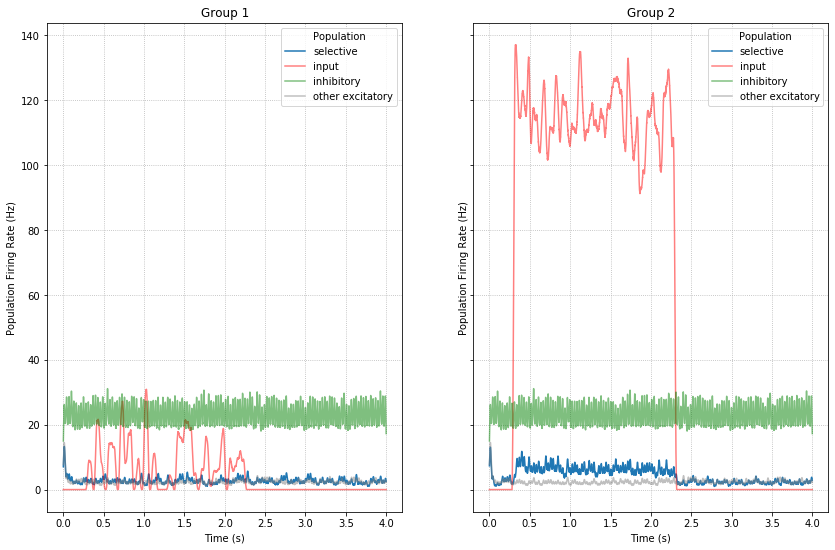

In [9]:
smooth_width = 10.0 * b2.ms

fig_rates, axes = b2.subplots(1, 2, figsize=(14, 9), sharey=True)
ax1, ax2 = axes

ax1.plot(
    ratemon_1.t,
    ratemon_1.smooth_rate(width=smooth_width), label='selective')
ax1.plot(
    ratemon_1.t,
    ratemon_input1.smooth_rate(width=smooth_width), color='red', alpha=0.5, label='input')
ax1.plot(
    ratemon_1.t,
    ratemon_inhibitory.smooth_rate(width=smooth_width), color='green', alpha=0.5, label='inhibitory')
ax1.plot(
    ratemon_1.t,
    ratemon_other.smooth_rate(width=smooth_width), color='gray', alpha=0.5, label='other excitatory')
ax1.legend(title='Population')
ax1.set_ylabel('Population Firing Rate (Hz)')
ax1.set_xlabel('Time (s)')
ax1.grid(linestyle=':')
ax1.set_title('Group 1')

ax2.plot(
    ratemon_2.t,
    ratemon_2.smooth_rate(width=smooth_width), label='selective')
ax2.plot(
    ratemon_2.t,
    ratemon_input2.smooth_rate(width=smooth_width), color='red', alpha=0.5, label='input')
ax2.plot(
    ratemon_2.t,
    ratemon_inhibitory.smooth_rate(width=smooth_width), color='green', alpha=0.5, label='inhibitory')
ax2.plot(
    ratemon_2.t,
    ratemon_other.smooth_rate(width=smooth_width), color='gray', alpha=0.5, label='other excitatory')
ax2.legend(title='Population')
ax2.set_ylabel('Population Firing Rate (Hz)')
ax2.set_xlabel('Time (s)')
ax2.grid(linestyle=':')
ax2.set_title('Group 2')

b2.show(fig_rates)

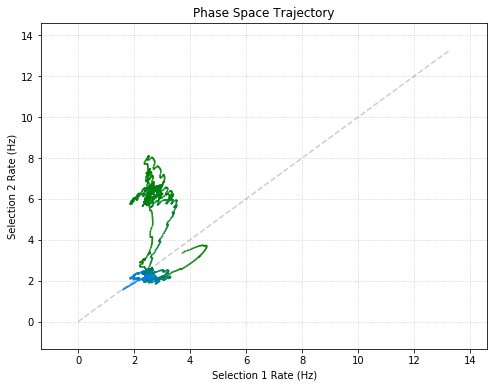

In [10]:
n = ratemon_1.t.shape[0]
green_to_blue = np.linspace(0, 1, n)**3

max_rate_1 = (ratemon_1.smooth_rate(width=smooth_width)/ b2.Hz).max()
max_rate_2 = (ratemon_2.smooth_rate(width=smooth_width) / b2.Hz).max()
max_rate = max(max_rate_1, max_rate_2)

b2.figure(figsize=(8,6))

seg_len = 10
for k in range(0, n-seg_len, seg_len):
    b2.plot(
        ratemon_1.smooth_rate(width=50*b2.ms)[k:k+seg_len+1] / b2.Hz,
        ratemon_2.smooth_rate(width=50*b2.ms)[k:k+seg_len+1] / b2.Hz,
        color=(0.0, 0.5, green_to_blue[k]),
        alpha=0.7
       )
b2.grid(linestyle=':', alpha=0.7)
b2.plot([0.0, max_rate], [0.0, max_rate], 'k--', alpha=0.2)
b2.xlim([-0.1*max_rate, max_rate + 0.1*max_rate])
b2.xlabel('Selection 1 Rate (Hz)')
b2.ylim([-0.1*max_rate, max_rate + 0.1*max_rate])
b2.ylabel('Selection 2 Rate (Hz)')
b2.title('Phase Space Trajectory')
b2.show()

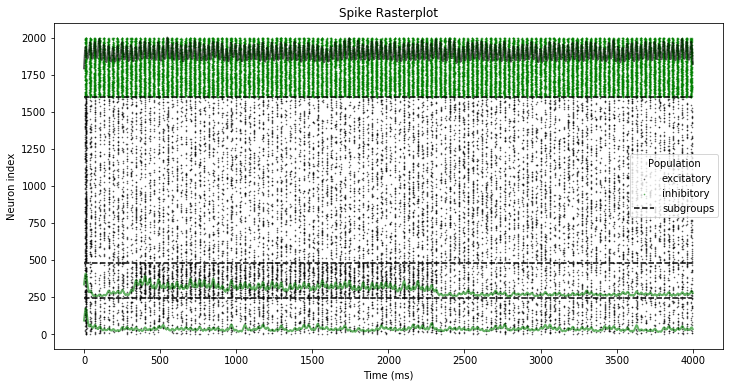

In [11]:
fig, ax = b2.subplots(1, 1, figsize=(12, 6))

s = 1.5
alpha = 0.6

ax.scatter(
    spikemon_excitatory.t / b2.ms,
    spikemon_excitatory.i,
    color='k', marker='.',
    label='excitatory',
    alpha=alpha,
    s=s
)
ax.scatter(
    spikemon_inhibitory.t / b2.ms,
    spikemon_inhibitory.i + N_E,
    color='g', marker='.',
    label='inhibitory',
    alpha=alpha,
    s=s
)
ax.hlines(
    [N_1, N_1 + N_2, N_E], [0] * 3,
    [spikemon_excitatory.t[-1]/b2.ms] * 3,
    linestyle='--',
    color='k',
    label='subgroups',
)
ax.set_ylabel('Neuron index')
ax.set_xlabel('Time (ms)')
ax.legend(title='Population')
ax.set_title('Spike Rasterplot')

max_rate_inhib = (ratemon_inhibitory.smooth_rate(width=smooth_width) / b2.Hz).max()
max_rate = max(max_rate, max_rate_inhib)
scale =  N_I / (max_rate * b2.Hz)
ax.plot(
    ratemon_1.t / b2.ms,
    ratemon_1.smooth_rate(width=smooth_width) * scale,
    color='g', linewidth=2,
    label='select 1',
    alpha=alpha
)
ax.plot(
    ratemon_2.t / b2.ms,
    ratemon_2.smooth_rate(width=smooth_width) * scale + N_1,
    color='g', linewidth=2,
    label='select 2',
    alpha=alpha
)
ax.plot(
    ratemon_inhibitory.t / b2.ms,
    ratemon_inhibitory.smooth_rate(width=smooth_width) * scale + N_E,
    color='k', linewidth=2,
    label='inhibitory',
    alpha=alpha
)
b2.show(fig)

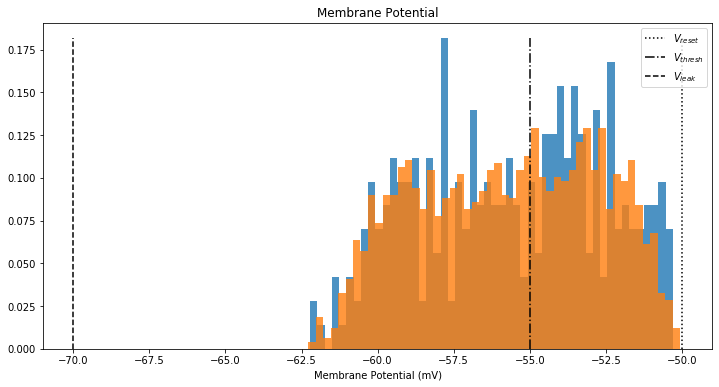

In [12]:
b2.figure(figsize=(12, 6))

timestep_stim_start = int(T_stim_start_initial / statemonitor_dt)
timestep_stim_end = int(T_stim_end_initial / statemonitor_dt)
h = b2.hist(
    statemon_excitatory.u[4, :timestep_stim_start] /b2.mV,
    bins=50,
    density=True,
    alpha=0.8
)
max_height = h[0].max()
h = b2.hist(
    statemon_excitatory.u[4, timestep_stim_start:timestep_stim_end] /b2.mV,
    bins=50,
    density=True,
    alpha=0.8
)
max_height = max(max_height, h[0].max())

b2.vlines(V_thresh / b2.mV, 0, max_height, 'k', linestyle=':', label=r'$V_{reset}$')
b2.vlines(V_reset / b2.mV, 0, max_height, 'k', linestyle='-.', label=r'$V_{thresh}$')
b2.vlines(V_leak / b2.mV, 0, max_height, 'k', linestyle='--', label=r'$V_{leak}$')

b2.xlabel('Membrane Potential (mV)')
b2.legend()
b2.title('Membrane Potential');

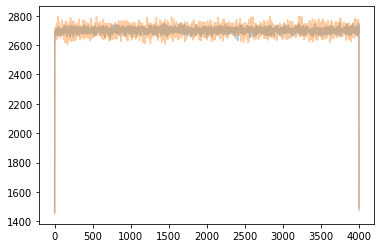

In [13]:
# plot the background noise
if not use_Poisson_input:  # I hate errors
    b2.plot(ratemon_noiseE.t/b2.ms, ratemon_noiseE.smooth_rate(width=1*b2.ms), alpha=0.4)
    b2.plot(ratemon_noiseI.t/b2.ms, ratemon_noiseI.smooth_rate(width=1*b2.ms), alpha=0.4)

In [14]:
# b2.figure(figsize=(12,8))

# cols = 'rgb'
# for source in range(3):
#     for neuron in range(100):
#         # one trace for each presynaptic neuron
#         b2.plot(
#             statemon_EI.t/b2.ms,
#             statemon_EI.x_NMDA[neuron + source*100,:],
#             color=cols[source],
#             alpha=0.2
#         )
# b2.show()
# # statemon_EI.s_AMPA.shape

Every plot in this image is red, green or blue, with some transparency. Every colour which arises stems from synchrony in the network:

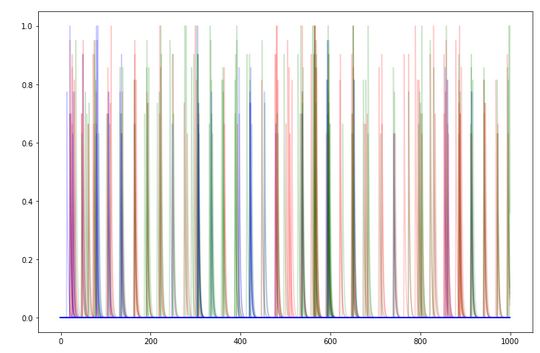

## Section: Packaging for Dask

We need to set up the code scaffold which takes parameters specified in the first cell, and runs it all as a function. Once we can parallelise, we can run it all simultaneously with DEAP (if that is at all possible).

One layout that will likely accomodate an evolutionary algorithm well is to create a function `run_simulation(model_params: Dict, simulation_params: Dict)` where `model_params` captures all the evolved/fitted features, and `simulation_params` captures all the simulated features. We won't need to store the results of the simulation (provided we use a random seed), just the parameters (for reproducibility) and the performance (for the EA). This can hopefully speed up the simulation.

However, the `model_params` and `simulation_params` dictionaries might not introduce their variables easily into the same scope that Brian2 looks at. There seem to be two ways around this:  
* create instead a `run_simulation(**all_params)` function where `all_params` consists of both sets of params; or  
* use a `network.run(..., namespace)` style Brian2 architecture, however that was implemented. This won't immediately work for neuron and synapse parameters though, as the network has to be defined before calling `network.run(...)`.